In [424]:
%matplotlib inline

from matplotlib.pyplot import *
import nest as sim
import numpy as np
import os
from scipy.io import loadmat

sim.ResetKernel()

sim_len = 100000

In [425]:
Nx = 34
Ny = int(np.ceil(Nx))
N = Nx * Ny

Px = Nx
Py = Px
P = Px * Py

Nx_in = 34
Ny_in = int(np.ceil(Nx))
N_in = Nx * Ny

sigma = 0.5/6
mu = 0.5

base_ex = 7200 #20*N
base_in = 1800 #5*N

base_cj = 100.
w_ex_cj = 650.

I_surround = 1

delay = 0.1

env_rad = 100 # denser place cells cause better bump movement

grid_space = 60 #cm
grid_phase = 0
grids = {}
spacex = grid_space/Nx
spacey = grid_space/Nx

base = 650.
sig = 2.
pspacex = (env_rad*2)/Px
pspacey = (env_rad*2)/Py 

In [426]:
# define place cell to grid cell weights

w_pc = np.ndarray((N,P))

# for every grid cell calculate centers of grid firing fields
for gc in range(N):
    grid_center = [(gc%Nx)*spacex, (gc//Nx)*spacey]
    centers = np.array([grid_center])
    for i in range(env_rad//grid_space+1):
        i+=1
        y = np.around(np.sin(grid_phase)*(i*grid_space),2)
        x = np.around(np.cos(grid_phase)*(i*grid_space),2)
            
        # horizontal
        centers =np.vstack((centers,np.add(grid_center,(x,y))))
        centers =np.vstack((centers,np.add(grid_center,(-x,-y))))

    # 60 degrees
    c = np.array([grid_center])
    for horz in centers:
        for i in range(env_rad//grid_space+1):
            i+=1
            y = np.around(np.sin(grid_phase+(np.pi/3))*(i*grid_space),2)
            x = np.around(np.cos(grid_phase+(np.pi/3))*(i*grid_space),2)

            c =np.vstack((c,np.add(horz,(x,y))))
            c =np.vstack((c,np.add(horz,(-x,-y))))
            c =np.vstack((c,np.add(horz,(-x,y))))
            c =np.vstack((c,np.add(horz,(x,-y))))
    centers =np.unique(np.vstack((centers,c)),axis=0)
    grids[gc] = centers
    
    
    # for every place cell calculate distance from centers of grid firing fields
    for pc in range(P):
        x = ((pc%Px)*pspacex) - env_rad
        y = ((pc//Px)*pspacey) - env_rad

        d = min(np.sqrt((x - centers[:,0])**2 + (y - centers[:,1])**2))
        w_pc[gc,pc] = np.around(base * (np.exp(-(d)**2/2/sig**2)),2)

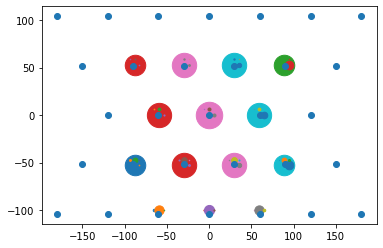

In [434]:
#plot showing example of place cells which are close to grid cell firing field centers
fig = figure()
plot(grids[0][:,0],grids[0][:,1],'o')

pspacex = (env_rad*2)/Px
pspacey = (env_rad*2)/Py
for pc in range(P):
    x = ((pc%Px)*pspacex) - env_rad
    y = ((pc//Px)*pspacey) - env_rad
    
    d = min(np.sqrt((x - grids[0][:,0])**2 + (y - grids[0][:,1])**2))
    w = np.around(base * (np.exp(-(d)**2/2/sig**2)),2)
    if w > 0:
        scatter(x,y,w)

In [ ]:
# define connection weights between excitatory and inhibitory layers

w_ex = np.empty((N_in,N))
w_in = np.empty((N,N_in))
for e in range(N):
    x_e = (e%Nx) / Nx
    y_e = (e//Nx)/ Ny
    for i in range(N_in): 
        x_i = (i%Nx_in) / Nx_in 
        y_i = (i//Nx_in) / Ny_in

        d1 = np.sqrt(abs(x_e - x_i)**2 + abs(y_e - y_i)**2)
        d2 = np.sqrt(abs(x_e - x_i - 1.)**2 + abs(y_e - y_i)**2)
        d3 = np.sqrt(abs(x_e - x_i + 1.)**2 + abs(y_e - y_i)**2)
        d4 = np.sqrt(abs(x_e - x_i)**2 + abs(y_e - y_i - 1.)**2)
        d5 = np.sqrt(abs(x_e - x_i)**2 + abs(y_e - y_i + 1.)**2)
        
        d = min(d1,d2,d3,d4,d5)


        w_gauss = np.exp(-(d)**2/2/sigma**2)
        w_ring = np.exp(-(d - mu)**2/2/sigma**2)


        if I_surround == 0:
            w_ex[i,e] = base_ex * w_ring
            w_in[e,i] = base_in * w_gauss
        else:
            w_ex[i,e] = base_ex * w_gauss
            w_in[e,i] = base_in * w_ring       
            
w_ex[w_ex<10]=0
w_in[w_in<10]=0

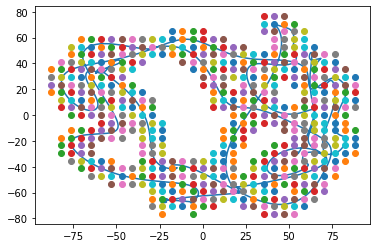

In [414]:
# from rat trajectories define input current to place cells

path = os.path.realpath('rat_trajectory_lowpass.mat')
ratData = loadmat(path)
rat_dt     = ratData['dt'][0][0]

posx  = ratData['pos_x'].ravel()
posy  = ratData['pos_y'].ravel()


dt = int(rat_dt*1000)
t = np.arange(0,(len(posx)*dt),dt)*1.

#DOWNSAMPLE
pos_x = []
pos_y = []
tt = []
for i in range(0,len(t),3):
    pos_x = np.append(pos_x, posx[i])
    pos_y = np.append(pos_y, posy[i])
    tt = np.append(tt, t[i])
    
time = [i * 1. for i in tt if i < sim_len]
time[0]=.1

fig = figure()
plot(pos_x[:len(time)],pos_y[:len(time)])

sig = 2.
params = []
threshold=400
for pc in range(P):
    x = ((pc%Px)*pspacex) - env_rad
    y = ((pc//Px)*pspacey) - env_rad
    d = np.sqrt(np.power(x - pos_x[:len(time)], 2) + np.power(y - pos_y[:len(time)], 2))
    gauss = np.around(100* np.exp(-(d)**2/2/sig**2),2)+threshold
    gauss[gauss == threshold] = 0
    if max(gauss)>threshold:
        plot(x,y,'o')
#         plot(gauss)
    params.append({'amplitude_times': time,'amplitude_values': gauss}) #time

In [415]:
# create neurons
exc = sim.Create("iaf_psc_alpha",N, params={"I_e": 400.})
inh = sim.Create("iaf_psc_alpha",N_in)
placeCells = sim.Create("iaf_psc_alpha",P) 

In [416]:
#connect network
exc_2_inh = sim.Connect(exc,inh,'all_to_all',syn_spec={'weight': w_ex, 'delay': delay})
inh_2_exc = sim.Connect(inh,exc,'all_to_all',syn_spec={'weight': -w_in, 'delay': delay})

pc_2_exc = sim.Connect(placeCells,exc,'all_to_all',syn_spec={'weight': w_pc, 'delay': delay})

I_input = sim.Create('step_current_generator', P, params)
sim.Connect(I_input,placeCells,'one_to_one')

In [417]:
I_init = 300.0 #pA
I_init_dur = 100.0 #ms
I_init_pos = 150 #55 #int(np.sqrt(N)) #//2

bump_init = sim.Create('step_current_generator', 1, params = {'amplitude_times':[0.1,0.1+I_init_dur],'amplitude_values':[I_init,0.0]})
sim.Connect(bump_init,[exc[I_init_pos]])

In [418]:
exc_spikes = sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True})
inh_spikes = sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True})
pc_spikes = sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True})

sim.Connect(exc,exc_spikes)
sim.Connect(inh,inh_spikes)
sim.Connect(placeCells,pc_spikes)

In [419]:
sim.Simulate(sim_len)

1116


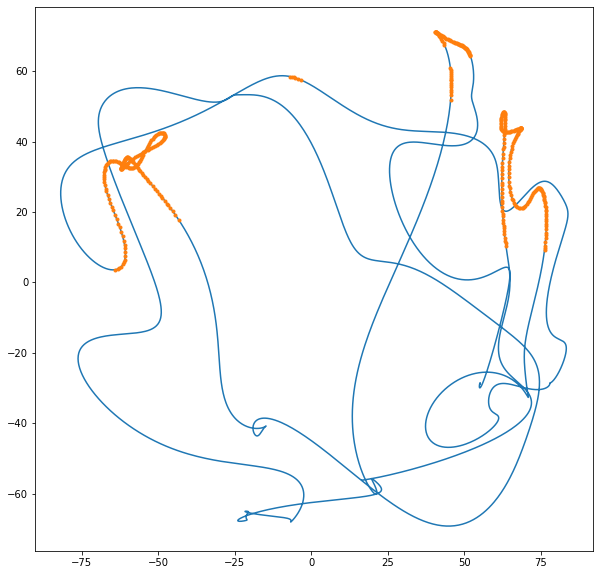

In [420]:
from collections import Counter 

%matplotlib inline

ratData = loadmat(path)
rat_dt     = ratData['dt'][0][0]
dt = int(rat_dt*1000)

rat_pos_x  = ratData['pos_x'].ravel()
rat_pos_y  = ratData['pos_y'].ravel()

t = list(range(0,(len(rat_pos_x)*dt),dt))
time = [i * 1. for i in t if i < sim_len]
t = [i * 1. for i in t]

ev = sim.GetStatus(exc_spikes)[0]['events']
t = ev['times']
sp = ev['senders']

cell = I_init_pos

occurence_count = Counter(sp) 
cell = occurence_count.most_common(1)[0][0]
print(cell)

spktms = t[sp==cell]
spktms = (spktms//20)*20
spktms=spktms[1:]

xs = np.empty((len(spktms)))
ys = np.empty((len(spktms)))

for i,spk in enumerate(spktms):
    xs[i] = rat_pos_x[np.where(time == spk)[0][0]]
    ys[i] = rat_pos_y[np.where(time == spk)[0][0]]
        
fig = figure(figsize=(10, 10),facecolor='w')
# plt.plot(x,y)
plot(rat_pos_x[:len(time)],rat_pos_y[:len(time)])
plot(xs,ys,'.')

In [421]:
def plotSpks(ax,t,s): # define function to plot spikes in a common way
    ax.plot(t,s,'.')
    ax.set_ylabel('Neuron')
    ax.set_xlabel('Time (ms)')
    ax.set_xlim([0,sim_len])

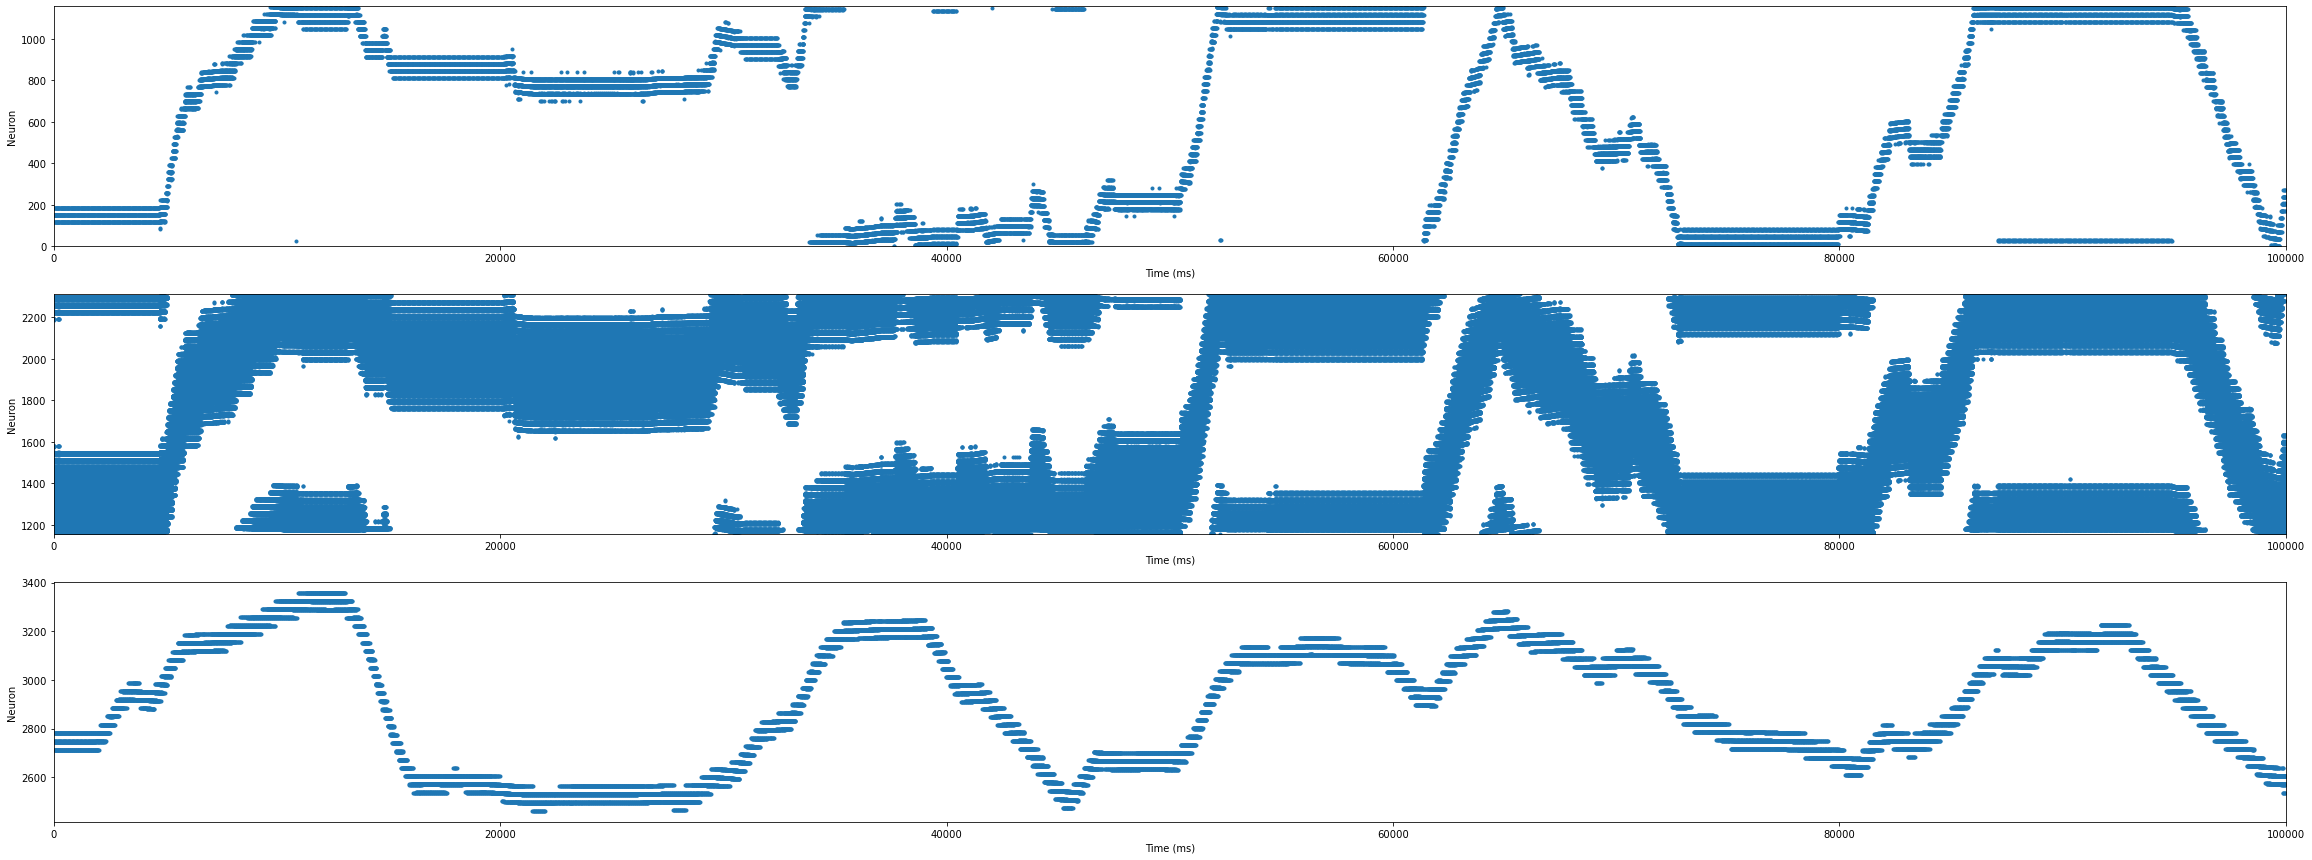

In [422]:
fig, (ax1, ax2, ax3) = subplots(3, 1,figsize=(40, 15),facecolor='w')

ev = sim.GetStatus(exc_spikes)[0]['events']
t = ev['times']
sp = ev['senders']
plotSpks(ax1,t,sp)
ax1.set_ylim([0,N])

ev = sim.GetStatus(inh_spikes)[0]['events']
t = ev['times']
sp = ev['senders']
plotSpks(ax2,t,sp)
ax2.set_ylim([N,N+N_in])

ev = sim.GetStatus(pc_spikes)[0]['events']
t = ev['times']
sp = ev['senders']
plotSpks(ax3,t,sp)
# ax3.set_ylim([N+N_in,N+N_in+P])